# Experiment

### Create function to train LSTM based on a ticker

In [1]:
import keras
keras.utils.set_random_seed(97) #Set seed for reproducibility

In [2]:
from single_preprocessing_function import single_preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras import optimizers
from keras.layers import Dropout

import matplotlib.pyplot as plt
import numpy as np

def single_ticker_lstm_use_case(ticker='DXCM', delay=5, lag=0, verbose=1):
    #get pre processed data using our previous built function
    X, y, ticker, delay, lag = single_preprocessing(ticker=ticker, delay=delay, lag=lag)

    #Confirm selected ticker
    if verbose == 1:
        print("Executing RNN-LSTM for selected ticker :",ticker)
        print("\n")
        print("delay :",delay," lag :",lag)
        print("\n")

    #dimentional check
    if X.shape[0] > y.shape[0]:
        X = X[:-1]
        if verbose == 1:
            print("Dimentional adjustment for X performed")
    else:
        if verbose == 1:
            print("Dimension check passsed")

    #Confirm shapes of X and y
    if verbose == 1:
        print("\n")
        print("Shape of X :")
        print(X.shape)
        print("\n")
        print("Shape of y :")
        print(y.shape)
        print("\n")

    if X.shape[0] == y.shape[0]:
        if verbose == 1:
            print("2nd Dimension check passed")
    else:
        assert X.shape[0] == y.shape[0], "The number of observations for X and y should be the same"
    print("\n")
    #Split data into test, validation, train
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    #RNN-LSTM architechture
    lstm_model = Sequential()
    lstm_model.add(layers.LSTM(units=70, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation="tanh" )) #add first layer for lstm
    lstm_model.add(Dropout(0.2))
    lstm_model.add(layers.LSTM(units=70, return_sequences=False, activation="tanh") ) #add second lstm layer
    lstm_model.add(Dropout(0.2))
    lstm_model.add(layers.Dense(1)) #don't add activation function because we are doing regression

    #Compile model and fit
    optimizer = optimizers.SGD(learning_rate=0.001, momentum=0.0, nesterov=False)
    lstm_model.compile(optimizer=optimizer, loss='mean_squared_error')
    lstm_history = lstm_model.fit(X_train, y_train, epochs=190, batch_size=30, validation_data=(X_val, y_val), verbose=verbose)

    #Make predictions
    predicted_stock_price = lstm_model.predict(X_test)

    #Evaluate model
    #Evaluate regression model using mse and map
    print("MSE for model: ")
    print(mean_squared_error(y_test, predicted_stock_price))
    print("\n")
    print("MAPE for model: ")
    print(mean_absolute_percentage_error(y_test, predicted_stock_price))

    return lstm_model, ticker, delay

### Create a function to fetch an observation of an specified ticker (last observation, most recent data)

In [3]:
#I'll just recylce the function we already built and slice the last observation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import MinMaxScaler

def single_preprocessing_use_case(ticker='SPLK', drop_col='Close', delay=15, lag=0):
    df = pd.read_pickle("./data/data_pkls/nasdaq100.pkl") #read data
    #Filter dataframe by this specific ticker
    df = df[ticker]
    #Drop missing values since there is no good way to estimate stock values that are not tracked
    df.dropna(inplace=True)
    #Drop Close column since it Adj Close column is calcualted using this information
    #so it would be allowing the model to cheat by already knowing the answers
    df.drop(columns={drop_col}, inplace=True)

    if drop_col == 'Close':
        organize_col = 'Adj Close'
    else:
        organize_col = 'Close'
    #Now just organize the columns 
    df = df.loc[:, ['Open', 'High', 'Low', 'Volume', organize_col]]
    #Now let's scale our data
    #First let's split data into X and Y
    X = df.loc[:, ['Open', 'High', 'Low', 'Volume']]
    y = df['Adj Close']
    scaler = MinMaxScaler() #create scaler object
    scaled_data = scaler.fit_transform(X) #fit transform data
    #Split data into samples and reshape X
    samples = [ scaled_data[i:i+delay] for i in range(0, (y.shape[0]), delay)]
    if len(samples[-1] < delay):
        samples = np.array(samples[:-1])
    else:
        samples = np.array(samples)
    #Reshape y target also
    new_y = [ y[i+delay+lag] for i in range(0, (y.shape[0]-(delay+lag)), delay)]
    new_y = np.array(new_y)

    #slice the last observation for this ticker
    samples = samples[-1]
    new_y = new_y[-1]
    return samples.reshape(1, delay, 4), new_y, ticker, delay, lag

### Now let's build the model and make a single prediction

In [9]:
#Build a model to predict the price of DXCM stock on the next day 
lstm, ticker, delay = single_ticker_lstm_use_case(ticker='DXCM', delay=5, lag=0, verbose=0)

c:\Users\kurom\Desktop\AI_GBC\S2\DL_I\Final_Project\single_preprocessing_function.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_y = [ y[i+delay+lag] for i in range(0, (y.shape[0]-(delay+lag)), delay)]




6/6 [==============================] - 1s 4ms/step
MSE for model: 
5.223589193415376


MAPE for model: 
0.11449825027110987


In [18]:
#Now let's get an observation to make a prediction
observation, target, _, _, lag = single_preprocessing_use_case(ticker=ticker, delay=delay, lag=0)

C:\Users\kurom\AppData\Local\Temp\ipykernel_12496\812133677.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_y = [ y[i+delay+lag] for i in range(0, (y.shape[0]-(delay+lag)), delay)]


In [19]:
#check the observation and it's target
observation

array([[[0.76481441, 0.78996096, 0.76464749, 0.03024883],
        [0.78372808, 0.80035873, 0.79384959, 0.02204056],
        [0.79123252, 0.7925148 , 0.79130757, 0.01908769],
        [0.77860311, 0.78983932, 0.78355755, 0.02035587],
        [0.78446019, 0.78801513, 0.7670655 , 0.02960418]]])

In [20]:
observation.shape

(1, 5, 4)

In [21]:
target

124.45999908447266

In [22]:
#Make prediction for observation
prediction = lstm.predict(observation)

1/1 [==============================] - 0s 37ms/step


In [25]:
#check prediction
prediction[0][0]

130.56157

# Test

### Test_1

In [4]:
import single_preprocessing_use_case
import single_Ticker_LSTM_use_case

In [30]:
#Now let's make a function that predicts the following 5 days of the value of the stock for a selected ticker
from single_preprocessing_function import single_preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras import optimizers
from keras.layers import Dropout

import matplotlib.pyplot as plt
import numpy as np
import keras

def lstm_use_case(ticker='DXCM', delay=5, lag_list=[0, 1, 2, 3, 4], verbose=0):
    keras.utils.set_random_seed(97) #Set seed for reproducibility
    #Sanity check
    if len(lag_list) > delay:
        assert "The number of days to predict ahead cannot be greater than delay, check lag_list and delay"
    #Init empty list to store predictions
    predictions_list = []
    #Train model and make predictions in a loop
    for lag in lag_list:
        #Build a model to predict the price of DXCM stock on the next day 
        lstm, _, _ = single_ticker_lstm_use_case(ticker=ticker, delay=delay, lag=lag, verbose=0)
        #Get observation
        observation, _, _, _, _ = single_preprocessing_use_case(ticker=ticker, delay=delay, lag=lag)
        #Make prediction
        prediction = lstm.predict(observation)
        #Add to list of predictions
        predictions_list.append(prediction[0][0])

    #Plot predictions for the next days
    lag_list = np.array(lag_list)+1
    plt.figure()
    plt.plot(lag_list, predictions_list, 'r', label='Predictions')
    plt.xlabel('Days ahead')
    plt.title('Predictions for the next '+str(len(lag_list))+' days')
    plt.legend()
    plt.show()


## Test_2

In [1]:
from single_preprocessing_use_case_function import single_preprocessing_use_case
from single_ticker_lstm_use_case_function import single_ticker_lstm_use_case

In [2]:
from lstm_use_case_function import lstm_use_case

c:\Users\kurom\Desktop\AI_GBC\S2\DL_I\Final_Project\single_preprocessing_function.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_y = [ y[i+delay+lag] for i in range(0, (y.shape[0]-(delay+lag)), delay)]



6/6 [==============================] - 1s 3ms/step
MSE for model: 
6.08213310481585


MAPE for model: 
0.05642760751418054
1/1 [==============================] - 0s 27ms/step


c:\Users\kurom\Desktop\AI_GBC\S2\DL_I\Final_Project\single_preprocessing_use_case_function.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_y = [ y[i+delay+lag] for i in range(0, (y.shape[0]-(delay+lag)), delay)]
c:\Users\kurom\Desktop\AI_GBC\S2\DL_I\Final_Project\single_preprocessing_function.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_y = [ y[i+delay+lag] for i in range(0, (y.shape[0]-(delay+lag)), delay)]




6/6 [==============================] - 1s 4ms/step
MSE for model: 
13.035209644719435


MAPE for model: 
0.0923352871772387
1/1 [==============================] - 0s 33ms/step


c:\Users\kurom\Desktop\AI_GBC\S2\DL_I\Final_Project\single_preprocessing_use_case_function.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_y = [ y[i+delay+lag] for i in range(0, (y.shape[0]-(delay+lag)), delay)]


c:\Users\kurom\Desktop\AI_GBC\S2\DL_I\Final_Project\single_preprocessing_function.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_y = [ y[i+delay+lag] for i in range(0, (y.shape[0]-(delay+lag)), delay)]


6/6 [==============================] - 1s 4ms/step
MSE for model: 
28.218476447261807


MAPE for model: 
0.15797749730355556
1/1 [==============================] - 0s 31ms/step


c:\Users\kurom\Desktop\AI_GBC\S2\DL_I\Final_Project\single_preprocessing_use_case_function.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_y = [ y[i+delay+lag] for i in range(0, (y.shape[0]-(delay+lag)), delay)]
c:\Users\kurom\Desktop\AI_GBC\S2\DL_I\Final_Project\single_preprocessing_function.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_y = [ y[i+delay+lag] for i in range(0, (y.shape[0]-(delay+lag)), delay)]




6/6 [==============================] - 1s 5ms/step
MSE for model: 
15.824746114895246


MAPE for model: 
0.430255186332595
1/1 [==============================] - 0s 40ms/step


c:\Users\kurom\Desktop\AI_GBC\S2\DL_I\Final_Project\single_preprocessing_use_case_function.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_y = [ y[i+delay+lag] for i in range(0, (y.shape[0]-(delay+lag)), delay)]


c:\Users\kurom\Desktop\AI_GBC\S2\DL_I\Final_Project\single_preprocessing_function.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_y = [ y[i+delay+lag] for i in range(0, (y.shape[0]-(delay+lag)), delay)]


6/6 [==============================] - 1s 3ms/step
MSE for model: 
15.062366048148949


MAPE for model: 
0.41931613856603694
1/1 [==============================] - 0s 40ms/step


c:\Users\kurom\Desktop\AI_GBC\S2\DL_I\Final_Project\single_preprocessing_use_case_function.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_y = [ y[i+delay+lag] for i in range(0, (y.shape[0]-(delay+lag)), delay)]


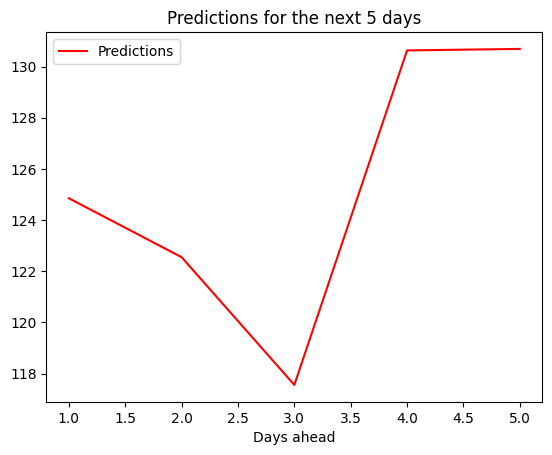

In [3]:
lstm_use_case(ticker='DXCM', delay=5, lag_list=[0, 1, 2, 3, 4], verbose=0)